# **Imports**

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torchvision import transforms as T
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import models
from glob import glob
from PIL import Image
import os
import imghdr
import cv2
from imagesize import imagesize
from torchmetrics import Accuracy
import warnings
warnings.filterwarnings('ignore')

# **Inits**

In [5]:
num_cls = 4

# **Units**

In [6]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# **Functions**

In [149]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, epoch=None):
    model.train()
    loss_train = AverageMeter()
    acc_train = Accuracy(task='multiclass', num_classes=num_cls).to(device)
    with tqdm(train_loader, unit="batch") as tepoch:
        try:
            for inputs, targets in tepoch:
                if epoch is not None:
                    tepoch.set_description(f"Epoch {epoch}")
                inputs = torch.FloatTensor(inputs).to(device)
                targets = torch.LongTensor(targets).to(device)
        
                outputs = model(inputs)
                
                loss = loss_fn(outputs.squeeze(1), targets)
                
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                
                loss_train.update(loss.item())
                acc_train(outputs.squeeze(1), targets.int())
                tepoch.set_postfix(loss=loss_train.avg,
                                   accuracy=100.*acc_train.compute().item())
        except:
            pass
    return model, loss_train.avg, acc_train.compute().item()

In [119]:
def validation(model, valid_loader, loss_fn):
    model.eval()
    with torch.no_grad():
        loss_valid = AverageMeter()
        acc_valid = Accuracy(task='multiclass', num_classes=num_cls).to(device)
        for i, (inputs, targets) in enumerate(valid_loader):
            inputs = torch.FloatTensor(inputs).to(device)
            targets = torch.LongTensor(targets).to(device)
            
            outputs = model(inputs)
            loss = loss_fn(outputs.squeeze(1), targets)
            
            loss_valid.update(loss.item())
            acc_valid(outputs.squeeze(1), targets.int())
    return loss_valid.avg, acc_valid.compute().item()

In [16]:
def cleansing(phase='adaspolo\\'):
    img_formats = ['jpeg','jpg', 'png']
    remove_count = 0
    root = 'files\\'
    for item in os.listdir(os.path.join(root, phase)):
        img_path = os.path.join(root, phase, item)
        try:
          img = cv2.imread(img_path)
          tip = imghdr.what(img_path)
          img_size = os.path.getsize(img_path)//1024
        except:
          os.remove(img_path)
          remove_count += 1
          continue
        if tip not in img_formats or img_size < 5.:
          os.remove(img_path)
          remove_count += 1
    print(f'Num of deleted images is: {remove_count}')

In [139]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

# **Preprocessing**

In [17]:
cleansing()

Num of deleted images is: 19


In [18]:
cleansing('fesenjun\\')

Num of deleted images is: 32


In [19]:
cleansing('koufteh\\')

Num of deleted images is: 26


In [20]:
cleansing('qeimeh\\')

Num of deleted images is: 34


In [28]:
class IranianFoods(Dataset):

    def __init__(self, transform ,root='files\\'):
        self.transform = transform
        im_list = []
        labels = []
        cls = [i for i in os.listdir(root)]
        idx_to_class = {i:j for i, j in enumerate(cls)}
        class_to_idx = {value:key for key,value in idx_to_class.items()}
        
        for classes in os.listdir(root):
            for item in os.listdir(os.path.join(root, classes)):
                img_path = os.path.join(root, classes, item)
                im_list.append(img_path)
                labels.append(class_to_idx[classes])

        self.images_list = im_list
        self.labels = torch.LongTensor(labels)

    def __getitem__(self, item):
        image_path = self.images_list[item]
        img = Image.open(image_path).convert('RGB')
        img = self.transform(img)
        label = self.labels[item].item()
        return img, label

    def __len__(self):
        return len(self.labels)

In [65]:
transform = T.Compose([T.Resize((224, 224)),
                       T.ToTensor()])

In [66]:
set = IranianFoods(transform=transform)

In [67]:
set.labels

tensor([0, 0, 0,  ..., 3, 3, 3])

In [68]:
train_set, test_set = random_split(set, [int(set.__len__()*0.8), set.__len__() - int(set.__len__()*0.8)])

In [69]:
train_loader = DataLoader(train_set, 50, True)
test_loader = DataLoader(test_set, 50, False)

# **Checking Datas**

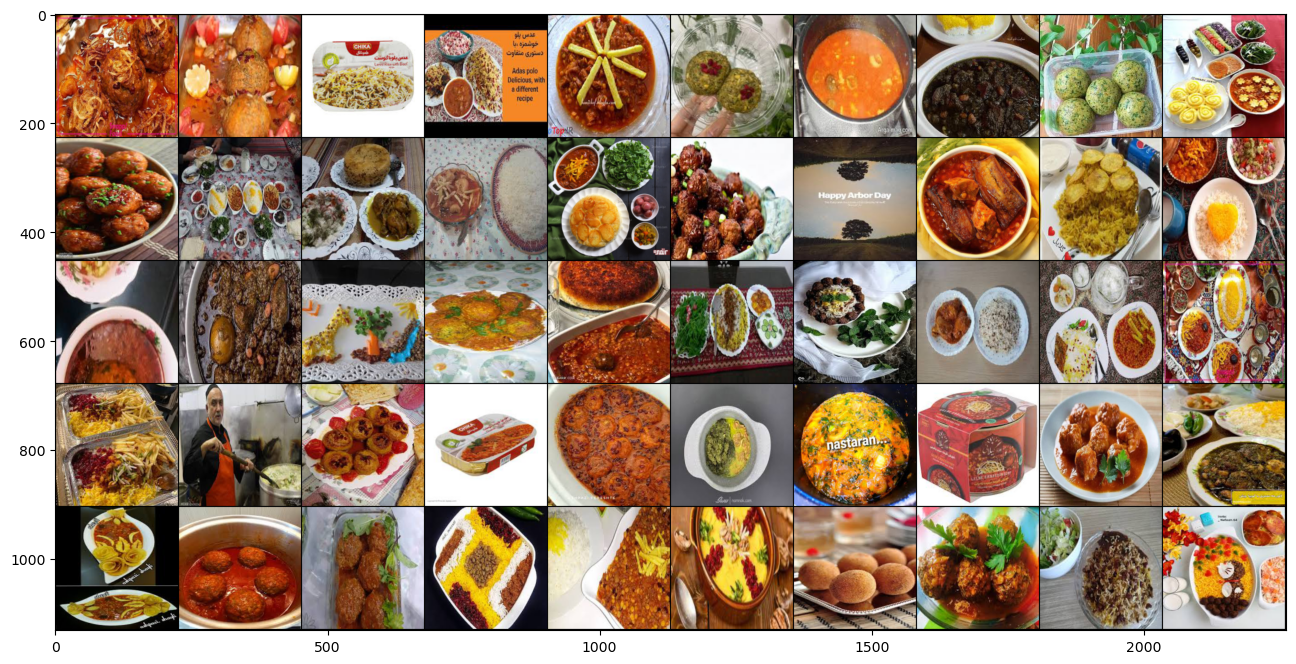

In [70]:
x, y = next(iter(train_loader))

img_grid = make_grid(x, nrow=10, normalize=True).permute(1, 2, 0)
plt.figure(figsize=(16, 8))
plt.imshow(img_grid)

# **Model**

In [79]:
class ResNetModel(nn.Module):

  def __init__(self):
    super().__init__()
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    self.model = nn.Sequential(*list(model.children())[:-2])
    self.conv1 = nn.LazyConv2d(256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    self.fc = nn.LazyLinear(4)

  def forward(self, x):
    y = self.model(x)
    y = self.conv1(y)
    y = self.avgpool(y)
    y = self.fc(y.flatten(1))
    return y

# **Train**

In [80]:
model = ResNetModel()

In [102]:
model.model.training = False

In [107]:
model.model.requires_grad_(False)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

## forward check

In [136]:
X, y = next(iter(train_loader))

model = ResNetModel()
model.model.requires_grad_(False)
loss_fn = nn.CrossEntropyLoss()

pred = model(X)
loss_fn(pred, y)

tensor(1.3936, grad_fn=<NllLossBackward0>)

In [138]:
num_trainable_params(model)

1.180932

## backward check

In [125]:
mini_set, _ = random_split(train_set, [100, len(train_set)-100])
mini_loader = DataLoader(mini_set, 10, True)

model = ResNetModel()
model.model.requires_grad_(False)
optimizer = optim.SGD(model.parameters(), lr=0.01)

for epoch in range(10):
    _, loss, acc =train_one_epoch(model, mini_loader, loss_fn, optimizer, epoch)

Epoch 9: 100%|██████████| 10/10 [00:02<00:00,  4.20batch/s, accuracy=97, loss=0.274] 


## train more epochs

In [150]:
model = ResNetModel()

In [151]:
train_loss = []
valid_loss = []
train_acc = []
valid_acc = []
counter = 0
best_loss_valid = torch.inf

In [154]:
model.model.requires_grad_(True)
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [155]:
for epoch in range(5):
    model, tr_loss, tr_acc = train_one_epoch(model,
                                     train_loader,
                                     loss_fn,
                                     optimizer,
                                     epoch)
    val_loss, val_acc = validation(model,
                                 test_loader,
                                 loss_fn)

    train_loss.append(tr_loss)
    train_acc.append(tr_acc)
    valid_loss.append(val_loss)
    valid_acc.append(val_acc)

    if val_loss < best_loss_valid:
        torch.save(model, 'classification.pth')
        best_loss_valid = val_loss
        print('model saved!')
    print(f'valid loss = {val_loss:.3}  valid acc = {val_acc:.3}')
    print()
    counter += 1

Epoch 0:  71%|███████▏  | 45/63 [02:08<00:51,  2.86s/batch, accuracy=80.8, loss=0.529]


model saved!
valid loss = 0.586  valid acc = 0.796



Epoch 1:  51%|█████     | 32/63 [01:34<01:31,  2.95s/batch, accuracy=83.4, loss=0.475]


model saved!
valid loss = 0.568  valid acc = 0.804



Epoch 2:  59%|█████▊    | 37/63 [01:51<01:18,  3.02s/batch, accuracy=84.6, loss=0.466]


model saved!
valid loss = 0.558  valid acc = 0.81



Epoch 3:  25%|██▌       | 16/63 [00:49<02:25,  3.09s/batch, accuracy=86.9, loss=0.404]


model saved!
valid loss = 0.553  valid acc = 0.808



Epoch 4:  98%|█████████▊| 62/63 [03:16<00:03,  3.17s/batch, accuracy=85.7, loss=0.427]


model saved!
valid loss = 0.541  valid acc = 0.806



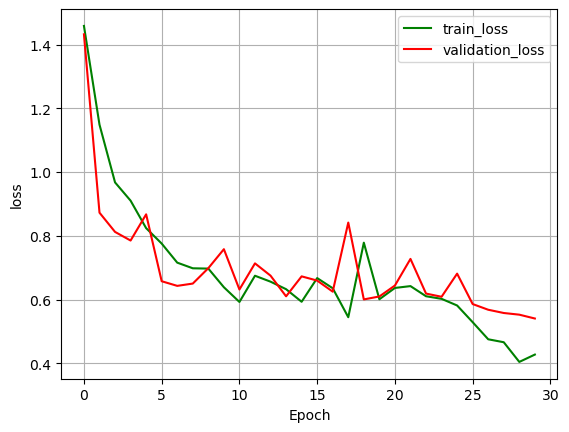

In [156]:
plt.plot(range(counter), train_loss, 'g-', label='train_loss')
plt.plot(range(counter), valid_loss, 'r-', label='validation_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

# **Test**

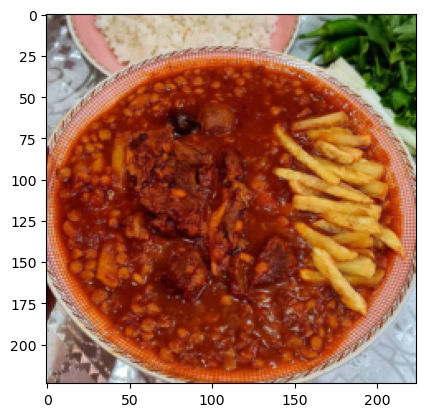

In [162]:
img = Image.open('test.jpg').convert('RGB')
img = transform(img).permute(1, 2, 0)
plt.imshow(img)

In [169]:
img = Image.open('test.jpg').convert('RGB')
img = transform(img).unsqueeze(0)
pred = torch.argmax(model(img)).item()

cls = [i for i in os.listdir('files\\')]
idx_to_class = {i:j for i, j in enumerate(cls)}
idx_to_class[pred]

'qeimeh'

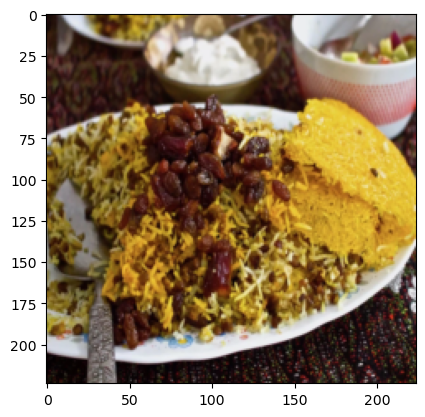

In [171]:
img = Image.open('test2.jpeg').convert('RGB')
img = transform(img).permute(1, 2, 0)
plt.imshow(img)

In [172]:
img = Image.open('test2.jpeg').convert('RGB')
img = transform(img).unsqueeze(0)
pred = torch.argmax(model(img)).item()

cls = [i for i in os.listdir('files\\')]
idx_to_class = {i:j for i, j in enumerate(cls)}
idx_to_class[pred]

'adaspolo'